# Importer tous les modules nécessaires

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import cv2
from collections import Counter
import seaborn as sns
from copy import deepcopy

# Préparation des données

In [47]:
# Chemin initial
root = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Catégories des images
categories = ['benign', 'malignant', 'normal'] # Label 0: benign, Label 1: malignant, Label 2: normal

# Initialiser des listes pour emmagasiner les chemins pour les images, images masqués et les étiquettes (0,1,2, etc.)
image_paths = []
labels = []
mask_paths = []

# Récupérer toutes les images
for label, category in enumerate(categories):
    
    # Récupérer le chemin actuel (soit un des trois dossiers: benign, malignant ou normal)
    chemin = os.path.join(root, category)

    # Récupérer le chemin de tous les fichiers d'un dossier
    current_files = os.listdir(chemin)

    # Récupérer les chemins des images originales d'un dossier
    images_originales = [f for f in current_files if 'mask' not in f]

    
    for img in images_originales:
        # Récupérer le nom de l'image (la fonction splitext retourne un tuple, d'où l'importance de préciser l'index 0)
        nom_image = os.path.splitext(img)[0]
        masked_image = f"{nom_image}_mask.png" # On récupère l'image masqué correspondantes

        if masked_image in current_files:
            
            # Listes des chemins menant aux images originales, les masques et les étiquettes
            image_paths.append(os.path.join(chemin, img))
            mask_paths.append(os.path.join(chemin, masked_image))
            labels.append(label)

## Séparer les données

In [48]:
# On sépare les données en 80-20 (80% des données sont dédiés à l'entraînement et le reste pour tester le modèle)
X_train, X_test, y_train, y_test, masked_train, masked_test = train_test_split(image_paths, labels, mask_paths, test_size=0.2, random_state=42, stratify=labels)

# Analyse exploratoire des données
Nous allons performer quelques analyses sur la base de données avant la création de notre modèle.

In [49]:
# Distribution des classes
class_counts = Counter(labels)
print("Nombre d'image totales par catégorie:")
df = pd.DataFrame({
    'Catégorie': categories,
    'Count': [class_counts[0], class_counts[1], class_counts[2]]
})

display(df)

# Analyse sur les dimensions des images
hauteur = []
largeur = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    hauteur.append(h)
    largeur.append(w)

print(f"\nDimensions des images:\nHauteur: Min={min(hauteur)}, Max={max(hauteur)}\nLargeur: Min={min(largeur)}, Max={max(largeur)}")

Nombre d'image totales par catégorie:


,Catégorie,Count
0,benign,437
1,malignant,210
2,normal,133



Dimensions des images:
Hauteur: Min=310, Max=719
Largeur: Min=190, Max=1048


<Figure size 1500x800 with 0 Axes>

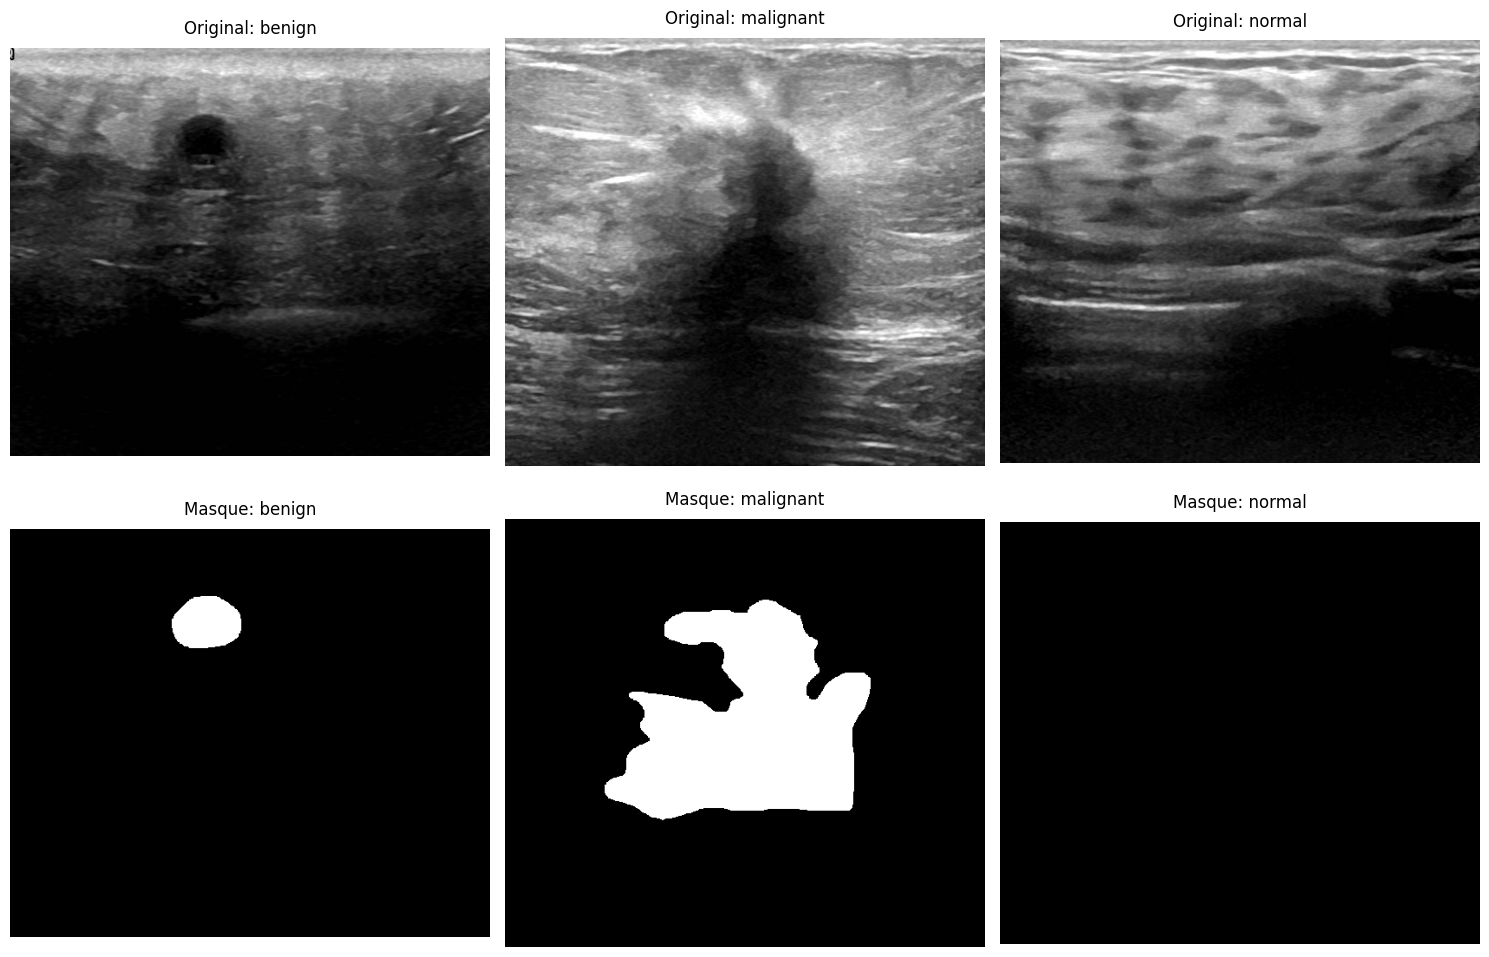

In [50]:
# Affichage d'un échantillon
plt.figure(figsize=(15, 8))
plt.suptitle("Échantillon d'une image originale et son masque dans chaque catégorie", 
             size=18, fontweight='bold',
             fontname='monospace', color="#1F1F1F", y=1.02)

# Nous affichons 3 images venant des catégories et leurs masques
num_categories = 3
fig, axes = plt.subplots(2, num_categories, figsize=(15, 10))

# Boucle pour itérer chaque catégorie
for i in range(num_categories):
    # Trouver la première image des données d'entraînement
    for j in range(len(y_train)):
        if y_train[j] == i:
            # Charger l'image et son masque
            original_img = cv2.imread(X_train[j])
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
            mask_img = cv2.imread(masked_train[j], cv2.IMREAD_GRAYSCALE)
            
            # Afficher l'image original au premier rang
            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f"Original: {categories[i]}", pad=10)
            axes[0, i].axis('off')
            
            # Afficher le masque au second rang
            axes[1, i].imshow(mask_img, cmap='gray')
            axes[1, i].set_title(f"Masque: {categories[i]}", pad=10)
            axes[1, i].axis('off')
            break

plt.tight_layout()

In [51]:
# Quantifier la distribution des régions atteintes de tumeurs (en utilisant les pixels blancs des masques)
mask_pixel_counts = []
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_pixel_counts.append(np.sum(mask > 0))  # Compter les pixels blancs

# Ajouter au DataFrame
df = pd.DataFrame({
    'Catégorie': [categories[l] for l in labels],
    'mask_pixels': mask_pixel_counts
})

# Group by 'Catégorie'
print("\nStatisques sur les images masqués (Région atteint par la tumeur):")
print(df.groupby('Catégorie').describe())


Statisques sur les images masqués (Région atteint par la tumeur):
          mask_pixels                                                        \
                count          mean           std    min       25%      50%   
Catégorie                                                                     
benign          437.0  20734.208238  28769.735793  804.0   4425.00  10263.0   
malignant       210.0  43376.852381  33076.910545  569.0  18006.25  34433.0   
normal          133.0      0.000000      0.000000    0.0      0.00      0.0   

                               
                75%       max  
Catégorie                      
benign     25108.00  209121.0  
malignant  57937.25  167411.0  
normal         0.00       0.0  


# Transformation des données
Création d'une classe pour transformer les données

In [52]:
# ===================================================================
# Classe d'assistance pour transformer les données --> ImageTransform
# ===================================================================
class ImageTransform:
    def __init__(self, image_transform, masked_transform):
        self.image_transform = image_transform
        self.masked_transform = masked_transform

    # Transformer les images et masques (en évitant l'utilisation de if-statements)
    def __call__(self, image, mask):
        return self.image_transform(image), self.masked_transform(mask)


# Transformation des images originales
image_training_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.RandomCrop(224), # Augmenter l'image avec random crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Statistiques de ImageNet
])

# Transformation des images de validation ***À MODIFIER (C'EST LA MÊME QUE image_training_transform)
image_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) 
])

# Transformation des images masqués (aucune normalisation)
masked_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Classe pour la base de données

In [53]:
# ==================================================================================
# Classe pour gérer la base de données d'images échographiques --> UltrasoundDataset
# ==================================================================================
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, masked_paths, labels, transform = None):
        self.image_paths = image_paths
        self.masked_paths = masked_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = cv2.cvtColor(cv2.imread(self.image_paths[index]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masked_paths[index], cv2.IMREAD_GRAYSCALE)
        label = self.labels[index]
        
        if self.transform:
            image, mask = self.transform(image, mask)

        # Calculer la superficie de la tumeur
        region_tumeur = torch.tensor([torch.sum(mask > 0).item() / (224*224)])

        return {
            'image': image,
            'masque': mask,
            'superficie_tumeur' : region_tumeur,
            'categorie' : torch.tensor(label, dtype = torch.long)
        }
        
# Données d'entraînement
training_dataset = UltrasoundDataset(
    X_train, 
    masked_train, 
    y_train, 
    transform = 
        ImageTransform(
            image_training_transform, 
            masked_transform
        ))

# Données de validation
val_dataset = UltrasoundDataset(
    X_test, 
    masked_test, 
    y_test,
    transform = 
        ImageTransform(
            image_val_transform, 
            masked_transform
        ))

# Création du modèle de machine learning

In [54]:
# ================================================================
# Classe de l'architecture du modèle CNN --> BreastUltrasoundModel
# ================================================================
class BreastUltrasoundModel(nn.Module):
    def __init__(self, num_classes = 3):
        super().__init__()
        
        # Images originales
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        
        # Images masquées
        self.mask_branch = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Région appartenant à la tumeur
        self.area_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )
        
        # Classifier combinés
        self.classifier = nn.Sequential(
            nn.Linear(num_features + 64*56*56 + 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, mask, region_tumeur):
        # Images
        img_features = self.backbone.conv1(x)
        img_features = self.backbone.bn1(img_features)
        img_features = self.backbone.relu(img_features)
        img_features = self.backbone.maxpool(img_features)
        img_features = self.backbone.layer1(img_features)
        img_features = self.backbone.layer2(img_features)
        img_features = self.backbone.layer3(img_features)
        img_features = self.backbone.layer4(img_features)
        img_features = self.backbone.avgpool(img_features)
        img_features = torch.flatten(img_features, 1)

        # Masques
        mask_features = self.mask_branch(mask)
        mask_features = torch.flatten(mask_features, 1)

        # Superficies de la tumeur
        superficie_features = self.area_fc(region_tumeur)

        # Features précédents combinés
        combined = torch.cat([img_features, mask_features, superficie_features], dim=1)
        return self.classifier(combined)

In [55]:
# ===========================================
# Classe pour l'Early Stopping
# ===========================================
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = 0
        self.best_model = None
        self.early_stop = False

    def __call__(self, val_accuracy, model):
        if val_accuracy > self.best_accuracy + self.min_delta:
            self.best_accuracy = val_accuracy
            self.best_model = deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# Setup et boucle d'entraînement du modèle

In [56]:
# =====================
# Boucle d'entraînement
# =====================
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch in loader:
        images = batch['image'].to(device)
        masks = batch['masque'].to(device)
        areas = batch['superficie_tumeur'].to(device)
        labels = batch['categorie'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images, masks, areas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss/len(loader), correct/total

In [57]:
# ===================================
# Poids des catégories non-équilibrés
# ===================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Poids des catégories non-équilibrés
categorie_counts = Counter(y_train)
total = sum(categorie_counts.values())
categorie_weights = torch.tensor([total/categorie_counts[i] for i in range(3)], dtype=torch.float32)

# Modèle et fonctions de perte/optimisation
model = BreastUltrasoundModel().to(device)
criterion = nn.CrossEntropyLoss(weight=categorie_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
early_stopping = EarlyStopping(patience=5)

# Data loaders
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Évaluation

In [58]:
# ====================
# Évaluation du modèle
# ====================
def evaluate(model, loader, criterion, categories):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            masks = batch['masque'].to(device)
            areas = batch['superficie_tumeur'].to(device)
            labels = batch['categorie'].to(device)
            
            outputs = model(images, masks, areas)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Rapport de classification
    print("\nRapport de classification:")
    print(classification_report(all_labels, all_preds, target_names=categories))
    
    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=categories, yticklabels=categories)
    plt.title("Matrice de confusion")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()
    
    return running_loss/len(loader), correct/total, all_preds, all_labels

# Éxecuter l'entraînement


Rapport de classification:
              precision    recall  f1-score   support

      benign       0.56      1.00      0.72        87
   malignant       0.00      0.00      0.00        42
      normal       0.00      0.00      0.00        27

    accuracy                           0.56       156
   macro avg       0.19      0.33      0.24       156
weighted avg       0.31      0.56      0.40       156



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


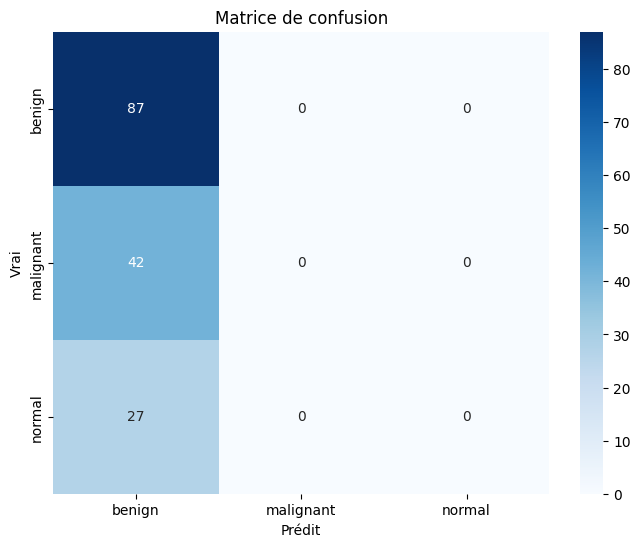


Epoch 1:
Perte durant l'entraînement: 27.3064 | Précision durant l'entraînement: 57.21%
Perte durant la validation: 195.7872 | Précision durant la validation: 55.77%
Meilleure précision validation: 55.77%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.72      0.71      0.72        87
   malignant       0.67      0.43      0.52        42
      normal       0.63      1.00      0.77        27

    accuracy                           0.69       156
   macro avg       0.67      0.71      0.67       156
weighted avg       0.69      0.69      0.67       156



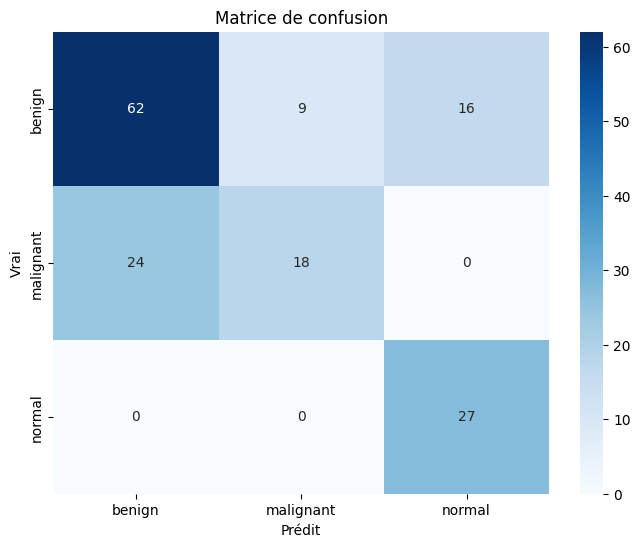


Epoch 2:
Perte durant l'entraînement: 8.7827 | Précision durant l'entraînement: 69.55%
Perte durant la validation: 10.2026 | Précision durant la validation: 68.59%
Meilleure précision validation: 68.59%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.73      0.76      0.75        87
   malignant       0.58      0.43      0.49        42
      normal       0.77      1.00      0.87        27

    accuracy                           0.71       156
   macro avg       0.70      0.73      0.70       156
weighted avg       0.70      0.71      0.70       156



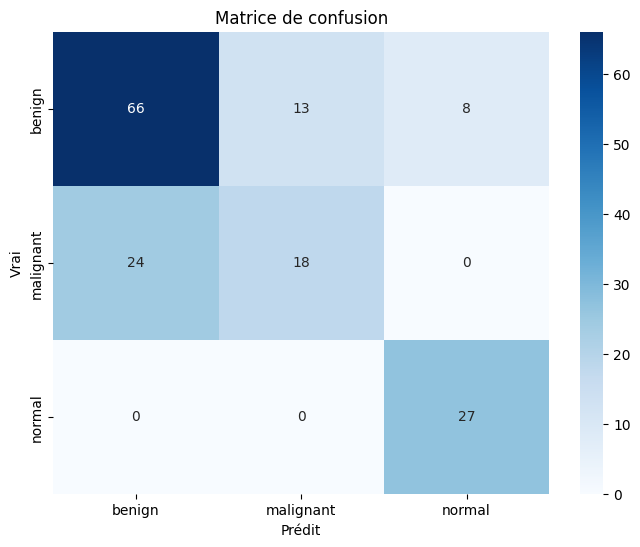


Epoch 3:
Perte durant l'entraînement: 3.2338 | Précision durant l'entraînement: 76.44%
Perte durant la validation: 3.1886 | Précision durant la validation: 71.15%
Meilleure précision validation: 71.15%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.75      0.75      0.75        87
   malignant       0.49      0.48      0.48        42
      normal       0.96      1.00      0.98        27

    accuracy                           0.72       156
   macro avg       0.73      0.74      0.74       156
weighted avg       0.71      0.72      0.72       156



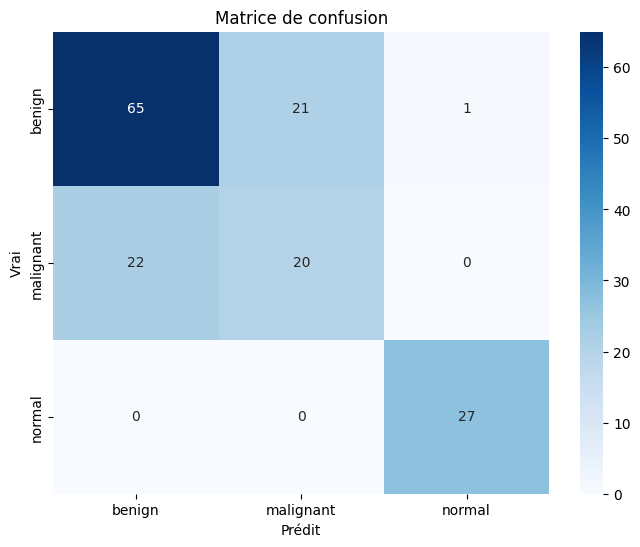


Epoch 4:
Perte durant l'entraînement: 2.2057 | Précision durant l'entraînement: 83.33%
Perte durant la validation: 2.0831 | Précision durant la validation: 71.79%
Meilleure précision validation: 71.79%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.84      0.83      0.83        87
   malignant       0.65      0.67      0.66        42
      normal       1.00      1.00      1.00        27

    accuracy                           0.81       156
   macro avg       0.83      0.83      0.83       156
weighted avg       0.82      0.81      0.81       156



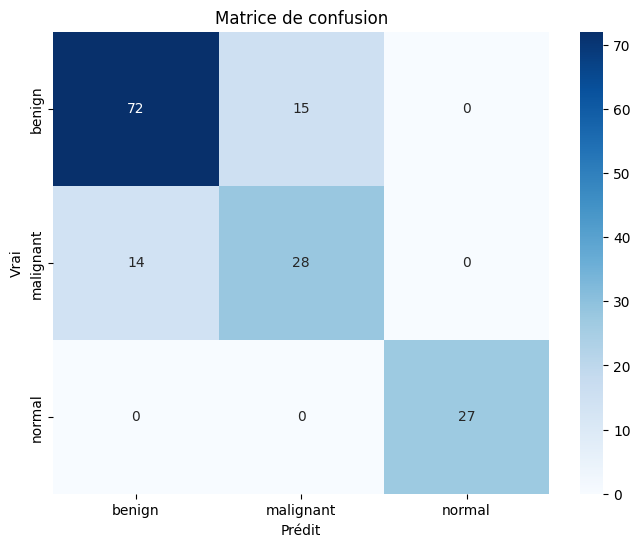


Epoch 5:
Perte durant l'entraînement: 1.3059 | Précision durant l'entraînement: 84.13%
Perte durant la validation: 1.5556 | Précision durant la validation: 81.41%
Meilleure précision validation: 81.41%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.72      0.86      0.79        87
   malignant       0.76      0.31      0.44        42
      normal       0.77      1.00      0.87        27

    accuracy                           0.74       156
   macro avg       0.75      0.72      0.70       156
weighted avg       0.74      0.74      0.71       156



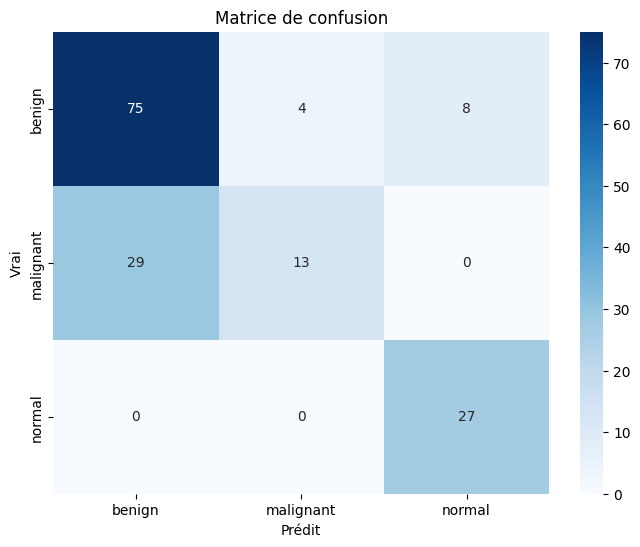


Epoch 6:
Perte durant l'entraînement: 0.5742 | Précision durant l'entraînement: 88.78%
Perte durant la validation: 2.4008 | Précision durant la validation: 73.72%
Meilleure précision validation: 81.41%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.83      0.82      0.82        87
   malignant       0.66      0.64      0.65        42
      normal       0.93      1.00      0.96        27

    accuracy                           0.80       156
   macro avg       0.81      0.82      0.81       156
weighted avg       0.80      0.80      0.80       156



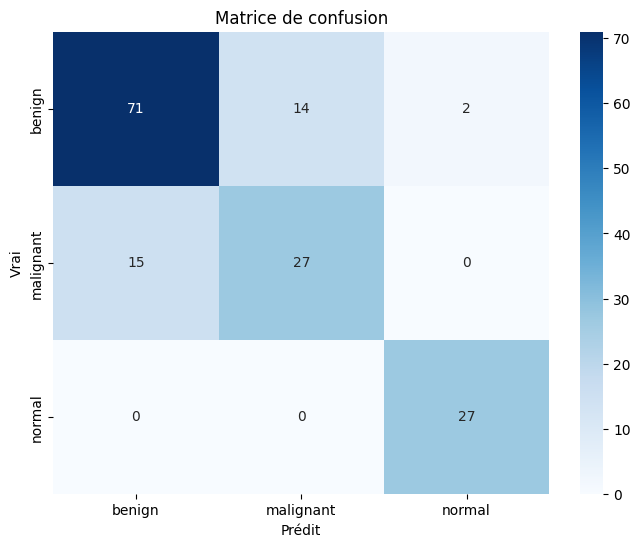


Epoch 7:
Perte durant l'entraînement: 0.4199 | Précision durant l'entraînement: 87.18%
Perte durant la validation: 0.8560 | Précision durant la validation: 80.13%
Meilleure précision validation: 81.41%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.82      0.83      0.82        87
   malignant       0.68      0.62      0.65        42
      normal       0.90      1.00      0.95        27

    accuracy                           0.80       156
   macro avg       0.80      0.82      0.81       156
weighted avg       0.80      0.80      0.80       156



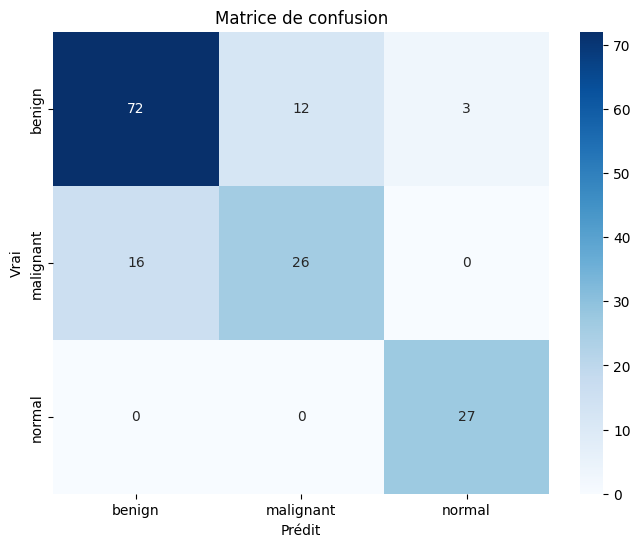


Epoch 8:
Perte durant l'entraînement: 0.5834 | Précision durant l'entraînement: 91.67%
Perte durant la validation: 1.0772 | Précision durant la validation: 80.13%
Meilleure précision validation: 81.41%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.75      0.89      0.81        87
   malignant       0.74      0.40      0.52        42
      normal       0.87      1.00      0.93        27

    accuracy                           0.78       156
   macro avg       0.79      0.76      0.76       156
weighted avg       0.77      0.78      0.76       156



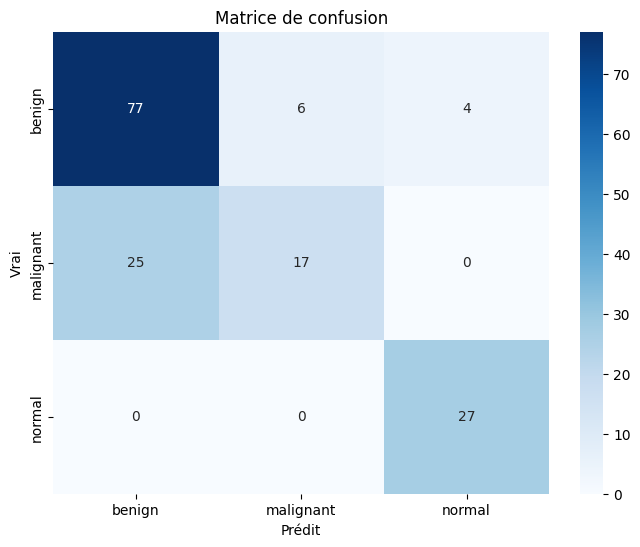


Epoch 9:
Perte durant l'entraînement: 0.2845 | Précision durant l'entraînement: 91.19%
Perte durant la validation: 1.2458 | Précision durant la validation: 77.56%
Meilleure précision validation: 81.41%
--------------------------------------------------

Rapport de classification:
              precision    recall  f1-score   support

      benign       0.82      0.76      0.79        87
   malignant       0.61      0.67      0.64        42
      normal       0.90      1.00      0.95        27

    accuracy                           0.78       156
   macro avg       0.78      0.81      0.79       156
weighted avg       0.78      0.78      0.78       156



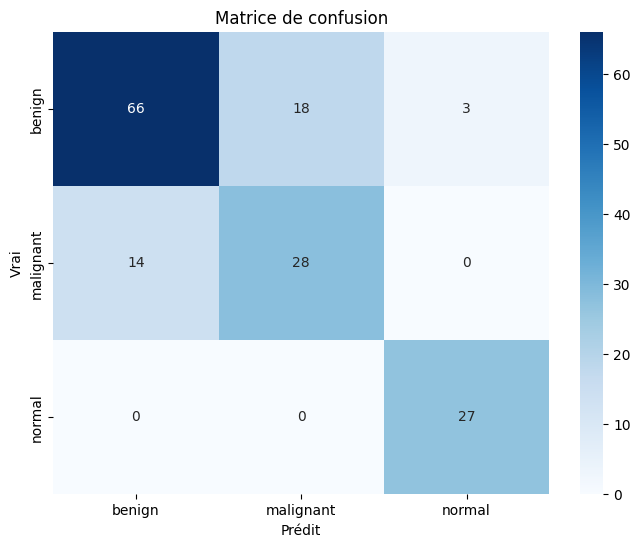

Early stopping déclenché!


In [59]:
# =======================
# Entraînement du modèle
# =======================
best_val_accuracy = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(20):
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    val_loss, val_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, categories)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Mise à jour du scheduler et early stopping
    scheduler.step(val_loss)
    
    if early_stopping(val_acc, model):
        print("Early stopping déclenché!")
        model.load_state_dict(early_stopping.best_model)
        break
    
    # Sauvegarde du meilleur modèle
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"\nEpoch {epoch+1}:")
    print(f"Perte durant l'entraînement: {train_loss:.4f} | Précision durant l'entraînement: {train_acc:.2%}")
    print(f"Perte durant la validation: {val_loss:.4f} | Précision durant la validation: {val_acc:.2%}")
    print(f"Meilleure précision validation: {best_val_accuracy:.2%}")
    print("-" * 50)

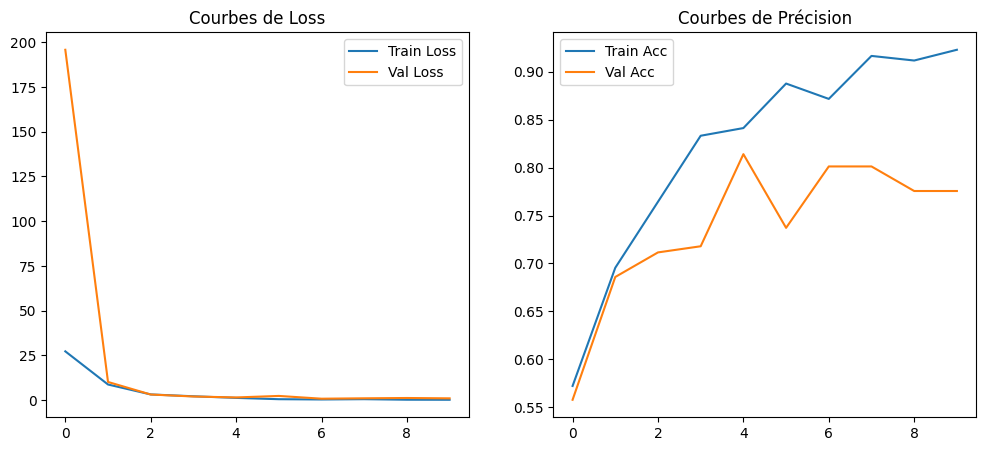

In [60]:
# ===========================================
# Visualisation des courbes d'apprentissage
# ===========================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Courbes de Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Courbes de Précision')
plt.legend()
plt.show()


Évaluation finale sur le meilleur modèle:


<ipython-input-61-098dc12e9bfc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Rapport de classification:
              precision    recall  f1-score   support

      benign       0.84      0.83      0.83        87
   malignant       0.65      0.67      0.66        42
      normal       1.00      1.00      1.00        27

    accuracy                           0.81       156
   macro avg       0.83      0.83      0.83       156
weighted avg       0.82      0.81      0.81       156



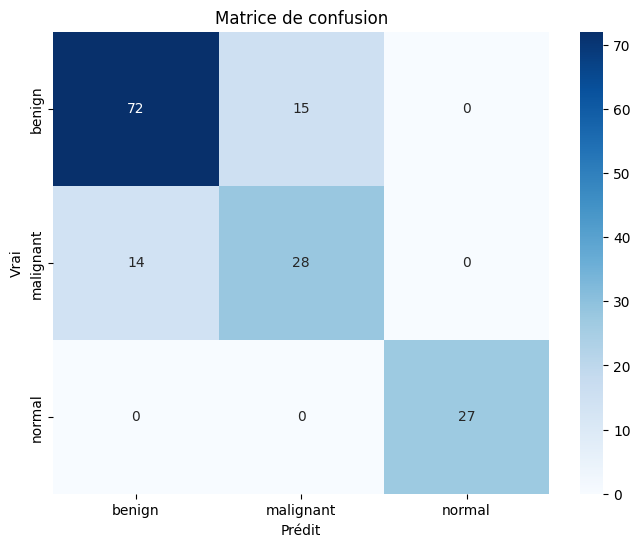

Précision finale: 81.41%


In [61]:
# ===========================================
# Évaluation finale sur le meilleur modèle
# ===========================================
print("\nÉvaluation finale sur le meilleur modèle:")
model.load_state_dict(torch.load('best_model.pth'))
final_loss, final_acc, _, _ = evaluate(model, test_loader, criterion, categories)
print(f"Précision finale: {final_acc:.2%}")

# Évaluation du modèle avancée

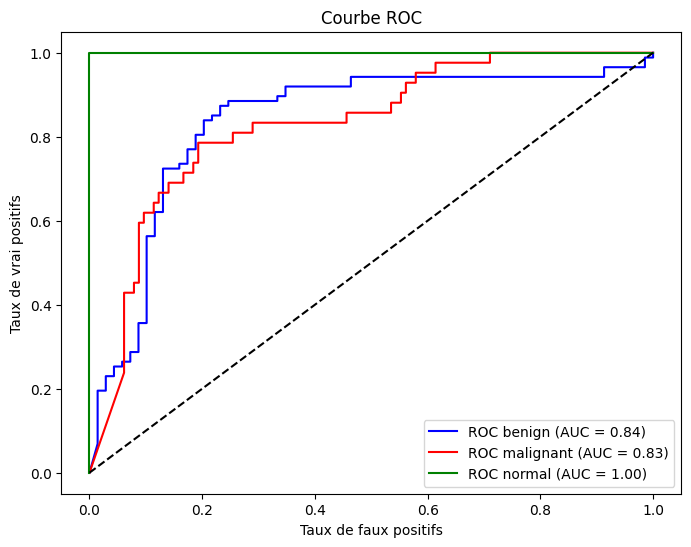

In [62]:
# ===========================
# Évaluation du modèle avancé
# ===========================
def plot_roc_curve(model, loader):
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            masks = batch['masque'].to(device)
            areas = batch['superficie_tumeur'].to(device)
            labels = batch['categorie'].to(device)
            
            outputs = model(images, masks, areas)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Étiquettes pour la courbe ROC
    y_true = label_binarize(all_labels, classes=[0,1,2])
    y_score = np.array(all_probs)
    
    # Générer ROC pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot
    plt.figure(figsize=(8,6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'ROC {categories[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrai positifs')
    plt.title('Courbe ROC')
    plt.legend()
    plt.show()

plot_roc_curve(model, test_loader)